In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (17.0, 77.0)

import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [3]:


def load_data(path):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        # if label != 'hcad':
        data_dict[label] = df[label].astype(float)
        # df[label][df[label] > 1] = 1.0

    # df['hcad'] = df['hcad'].astype(float)
    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    return result.sort(['hcad']).fillna(0)
def display_heightmap(mat):
    plt.imshow((mat), interpolation='nearest')
    plt.show()


In [4]:
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")

loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode


In [5]:


wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

def feet_to_lon_lat(x,y):
    x = [x*.3048] # convert to meters
    y = [y*.3048]
    return pyproj.transform(UTM26N, wgs84, x, y)



In [6]:
from os import listdir
from os.path import isfile, join

file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

#     pickle_path = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/" + filename + ".npy"
#     f = file(pickle_path,"wb")
#     mat = np.loadtxt(mypath + "/" + filename, dtype='float16', comments='#', delimiter=" ", converters=None, skiprows=6, usecols=range(0,attributes['ncols']), unpack=False, ndmin=0)
#     np.save(f, mat)
#     f.close()
    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"

loaded all file header attributes into dict


In [7]:
from collections import deque
def display(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
def memoize(obj, maxlen = 20):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]

    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split
#         print image_slice(ul, housex, housey).shape
#         print image_slice(ur, housex, housey).shape
#         print image_slice(ll, housex, housey).shape
#         print image_slice(lr, housex, housey).shape
#         print ul
#         print ur
#         print ll
#         print lr
#         print feet_to_lon_lat(housex, housey)

#         display(image_slice(ul, housex, housey))
#         display(image_slice(lr, housex, housey))

        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
#         print upper_slice.shape
#         print lower_slice.shape

#         assert(upper_slice.shape[1] == lower_slice.shape[1])
#         assert(upper_slice.shape[0] + lower_slice.shape[0] == window_width_pixels)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice
#         plt.imshow(result)
#         plt.show()


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

    

#     key = get_file_containing(x,y)
#     block = file_attributes[key]
#     mat = load_mat_from_file(key)
#     imagex = (int(x)-block['xllcorner'])/5
#     imagey = (int(y)-block['yllcorner'])/5

#     x1 = np.max([0,              imagex - window_width_pixels/2])
#     x2 = np.min([block['ncols'], imagex+window_width_pixels/2])

#     y1 = np.max([0,              imagey - window_width_pixels/2])
#     y2 = np.min([block['nrows'], imagey+window_width_pixels/2])


#     result = mat[block['nrows']-y2:block['nrows']-y1, x1:x2]
#     return result


def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1

In [10]:
image_width = 40

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
get_heightmap_around(housex,housey)

n=10000
metamat = np.zeros([len(meta),1,image_width,image_width])
# metamat = metamat.astype(float32)
metaY = np.zeros([len(meta)])



# print "number 3767"
# lon = [meta['lon'][3767]]
# lat = [meta['lat'][3767]]
# print lat,lon
# xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
# housex=xx[0]
# housey=yy[0]
# new_element = get_heightmap_around(housex, housey, window_width_pixels=image_width)
# print new_element.shape




for index in range(len(meta)):
    
#     index = rand.randint(0, len(meta)-1)
    lon = [meta['lon'][index]]
    lat = [meta['lat'][index]]

    xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
    housex=xx[0]
    housey=yy[0]
    
    
    new_element = get_heightmap_around(housex, housey, window_width_pixels=image_width)
    if(new_element == None):
        print index
        break
    if index%1000 == 0:
        print index
        
    
    
    new_element = np.array([new_element])
    metamat[index] = new_element
    metamat[index] = metamat[index] - np.min(metamat[index])

    metaY[index] = y_data['y'][index]




house lat lon [29.920000076293945] [-95.084800720214844]
[977962.9843141946] [4237588.749906508]
0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [12]:
np.save("40x40every_house", metamat)

In [ ]:
np.save("all_y.np", metamat)

house lat lon [29.920000076293945] [-95.084800720214844]
[977962.9843141946] [4237588.749906508]


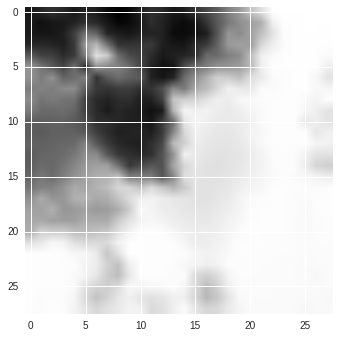

In [200]:

lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
plt.imshow(get_heightmap_around(housex, housey))
plt.show()

In [ ]:
metamat /= (metamat.max()/2.0) + 1.0
print metamat.shape
print np.min(metamat), np.max(metamat)


# print metamat
# print metaY
f = file("20000Random100x100Slices.np","wb")
np.save(f, metamat)
f.close()

f = file("20000RandomY.np","wb")
np.save(f, metaY)
f.close()

In [10]:
plt.imshow(mat[:,:])
plt.show()

TypeError: 'function' object has no attribute '__getitem__'

You can compare the image displayed here with google maps to convince yourself that this is the correct map in the right orientation

ncols         4084
nrows         4655
xllcorner     2957465
yllcorner     13901720
cellsize      5
NODATA_value  -9999

([-95.87719724468919], [29.937664918477612])


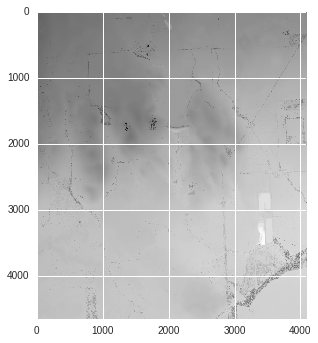

In [47]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q116.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q116.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(2957465, 13901720)
display_heightmap(matloaded)

ncols         4105
nrows         4665
xllcorner     3059015
yllcorner     13813630
cellsize      5
NODATA_value  -9999

([-95.49806581999147], [29.750130089434883])


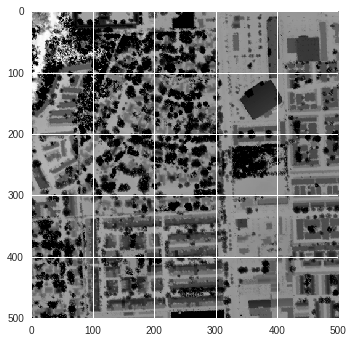

In [48]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q247.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q247.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(3059015+4105*5, 13813630+4665*5)
display_heightmap(matloaded[:500,4105-500:].clip(-100,100))